In [1]:
import sys
try:
    import google.colab
    ENV_IS_CL = True
    !git clone --single-branch --branch network https://github.com/jameshalgren/wrf_hydro_nwm_public.git
    sys.path.append('/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/src/python_framework')
    !pip install geopandas
    !pip install netcdf4
    #default recursion limit (~1000) is slightly too small for the deepest branches of the network
    sys.setrecursionlimit(6000) 
    #TODO: convert recursive functions to stack-based functions
except:
    ENV_IS_CL = False
    sys.path.append(r'../src/python_framework')


In [2]:
import networkbuilder as networkbuilder
import recursive_print
import os
import geopandas as gpd
import pandas as pd
import xarray as xr
# -*- coding: utf-8 -*-
"""NHD Network traversal

A demonstration version of this code is stored in this Colaboratory notebook:
https://colab.research.google.com/github/jameshalgren/wrf_hydro_nwm_public/blob/network/trunk/NDHMS/dynamic_channel_routing/notebooks/NHD_Network_Density_Analysis.ipynb#scrollTo=h_BEdl4LID34

"""
def do_network(
        geofile_path = None
        , title_string = None
        , layer_string = None
        , driver_string = None
        , key_col = None
        , downstream_col = None
        , length_col = None
        , terminal_code = None
        , verbose = False
        , debuglevel = 0
        ):

    # NOTE: these methods can lose the "connections" and "rows" arguments when
    # implemented as class methods where those arrays are members of the class.
    if verbose: print(title_string)
    if driver_string == 'NetCDF':
        geofile = xr.open_dataset(geofile_path)
        geofile_rows = (geofile.to_dataframe()).values
        # The xarray method for NetCDFs was implemented after the geopandas method for 
        # GIS source files. It's possible (probable?) that we are doing something 
        # inefficient by converting away from the Pandas dataframe.
        # TODO: Check the optimal use of the Pandas dataframe
        if debuglevel <= -1: print(f'reading -- dataset: {geofile_path}; layer: {layer_string}; driver: {driver_string}')
    else:
        if debuglevel <= -1: print(f'reading -- dataset: {geofile_path}; layer: {layer_string}; fiona driver: {driver_string}')
        geofile = gpd.read_file(geofile_path, driver=driver_string, layer=layer_string)
        geofile_rows = geofile.to_numpy()
    if debuglevel <= -2: geofile.plot() #TODO: WILL THIS WORK WITH NetCDF???
    if debuglevel <= -1: print(geofile.head()) #TODO: WILL THIS WORK WITH NetCDF???
    # Kick off recursive call for all connections and keys
    (connections) = networkbuilder.get_down_connections(
                    rows = geofile_rows
                    , key_col = key_col
                    , downstream_col = downstream_col
                    , length_col = length_col
                    , verbose = verbose
                    , debuglevel = debuglevel)
    
    (all_keys, ref_keys, headwater_keys
        , terminal_keys
        , terminal_ref_keys
        , circular_keys) = networkbuilder.determine_keys(
                    connections = connections
#                     , rows = geofile_rows
                    , key_col = key_col
                    , downstream_col = downstream_col
                    , terminal_code = terminal_code
                    , verbose = verbose
                    , debuglevel = debuglevel)
    
    (junction_keys) = networkbuilder.get_up_connections(
                    connections = connections
                    , terminal_code = terminal_code
                    , headwater_keys = headwater_keys
                    , terminal_keys = terminal_keys
                    , verbose = verbose
                    , debuglevel = debuglevel)
    return connections, all_keys, ref_keys, headwater_keys \
        , terminal_keys, terminal_ref_keys \
        , circular_keys, junction_keys

In [3]:
def do_print():    
    recursive_print.print_basic_network_info(
                    connections = connections_NHD
                    , headwater_keys = headwater_keys_NHD
                    , junction_keys = junction_keys_NHD
                    , terminal_keys = terminal_keys_NHD
                    , terminal_code = terminal_code_NHD
                    , verbose = True
                    )
    
    if 1 == 0: #THE RECURSIVE PRINT IS NOT A GOOD IDEA WITH LARGE NETWORKS!!!
        recursive_print.print_connections(
                    headwater_keys = headwater_keys_NHD
                    , down_connections = connections_NHD
                    , up_connections = connections_NHD
                    , terminal_code = terminal_code_NHD
                    , terminal_keys = terminal_keys_NHD
                    , terminal_ref_keys = terminal_ref_keys_NHD
                    , debuglevel = -2
                    )
    


### Two Real Networks

In [4]:
if ENV_IS_CL: root = '/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/'
elif not ENV_IS_CL: root = os.path.dirname(os.path.abspath(''))
test_folder = os.path.join(root, r'test')
geo_input_folder = os.path.join(test_folder, r'input', r'geo', r'Channels')

"""##NHD Subset (Brazos/Lower Colorado)"""
Brazos_LowerColorado_ge5 = True
"""##NHD CONUS order 5 and greater"""
CONUS_ge5 = True
"""These are large -- be careful"""
CONUS_FULL_RES = True
CONUS_Named_Streams = False #create a subset of the full resolution by reading the GNIS field
CONUS_Named_combined = False #process the Named streams through the Full-Res paths to join the many hanging reaches

debuglevel = -1
verbose = True

# The CONUS_ge5 and Brazos_LowerColorado_ge5 datasets are included
# in the github test folder and are extracts from the NHD version 1.2 datasets
# from https://www.nohrsc.noaa.gov/pub/staff/keicher/NWM_live/web/data_tools/
#  
# The CONUS_FULL_RES file was generated from the RouteLink file in the parameter
# archive and converted to a compressed NetCDF via the following command:
# nccopy -d1 -s RouteLink_NWMv2.0_20190517_cheyenne_pull.nc RouteLink_NWMv2.0_20190517_cheyenne_pull.nc4s
# TODO: Explain CONUS_Named_Streams
# CONUS_Named_Streams was generated by intersecting the FULL_RES file ...
# of the data in the nohrsc-hosted archive but are too large to efficiently 
# package inside of the repository. 

if Brazos_LowerColorado_ge5:
    nhd_conus_file_path = os.path.join(geo_input_folder
            , r'NHD_BrazosLowerColorado_Channels.shp')
    key_col_NHD = 2
    downstream_col_NHD = 7
    length_col_NHD = 6
    terminal_code_NHD = 0
    title_string = 'Brazos + Lower Colorado\nNHD stream orders 5 and greater\n'
    title_string = 'CONUS Order 5 and Greater '
    driver_string = 'ESRI Shapefile'
    layer_string = 0

    Brazos_LowerColorado_ge5_values = do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)

if CONUS_ge5:
    nhd_conus_file_path = os.path.join(geo_input_folder
            , r'NHD_Conus_Channels.shp')
    key_col_NHD = 1
    downstream_col_NHD = 6
    length_col_NHD = 5
    terminal_code_NHD = 0
    title_string = 'CONUS Order 5 and Greater '
    driver_string = 'ESRI Shapefile'
    layer_string = 0

    CONUS_ge5_values = do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)

if CONUS_FULL_RES:
    # nhd_conus_file_path = '../../../../../../GISTemp/nwm_v12.gdb'
    nhd_conus_file_path = os.path.join(geo_input_folder
            , r'RouteLink_NWMv2.0_20190517_cheyenne_pull.nc')
    key_col_NHD = 0
    downstream_col_NHD = 2
    length_col_NHD = 10
    terminal_code_NHD = 0
    title_string = 'CONUS Full Resolution NWM v2.0'
    # driver_string = 'FileGDB'
    driver_string = 'NetCDF'
    # layer_string = 'channels_nwm_v12_routeLink'
    layer_string = 0

    CONUS_FULL_RES_values = do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)

CONUS Order 5 and Greater 
reading -- dataset: /home/jacob.hreha/nwm/trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/NHD_BrazosLowerColorado_Channels.shp; layer: 0; fiona driver: ESRI Shapefile
   OBJECTID_1  OBJECTID  featureID  linkDim     link  order_  Length       to  \
0        1499     25442    3764288   460086  3764288       6  2150.0  3764296   
1        1500     25443    3764296   460088  3764296       6  1277.0  3765756   
2        1501     25444    3766380   460092  3766380       6   431.0  3766382   
3        1502     25445    3765756   460090  3765756       6  1274.0  3766380   
4        1503     25447    3765796   460180  3765796       6   219.0  3765798   

     MusK  MusX  ...  gages  NHDWaterbo      lat      lon   alt Kchan  \
0  3600.0   0.2  ...   None       -9999  29.0176 -96.0119  9.59     0   
1  3600.0   0.2  ...   None       -9999  29.0059 -96.0029  9.59     0   
2  3600.0   0.2  ...   None       -9999  28.9876 -95.9992  9.59     0   
3  3600.0   0.2

In [5]:
# def main():
if 1 == 1:
    """##TEST"""
    print("")
    print ('Executing Test')
    # Test data
    test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

    test_key_col = 0
    test_downstream_col = 2
    test_length_col = 1
    test_terminal_code = -999
    debuglevel = -2
    verbose = True

    (test_connections) = networkbuilder.get_down_connections(
                rows = test_rows
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , length_col = test_length_col
                , verbose = True
                , debuglevel = debuglevel
                )

    (test_all_keys, test_ref_keys, test_headwater_keys
     , test_terminal_keys
     , test_terminal_ref_keys
     , test_circular_keys) = networkbuilder.determine_keys(
                connections = test_connections
                
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = debuglevel
                )

    test_junction_keys = networkbuilder.get_up_connections(
                connections = test_connections
                , terminal_code = test_terminal_code
                , headwater_keys = test_headwater_keys
                , terminal_keys = test_terminal_keys
                , verbose = True
                , debuglevel = debuglevel
                )

    recursive_print.print_connections(
                headwater_keys = test_headwater_keys
                , down_connections = test_connections
                , up_connections = test_connections
                , terminal_code = test_terminal_code
                , terminal_keys = test_terminal_keys
                , terminal_ref_keys = test_terminal_ref_keys
                , debuglevel = debuglevel
                )

    recursive_print.print_basic_network_info(
                connections = test_connections
                , headwater_keys = test_headwater_keys
                , junction_keys = test_junction_keys
                , terminal_keys = test_terminal_keys
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = debuglevel
                )


# if __name__ == "__main__":
#     main()



Executing Test
down connections ...
found 16 segments
{0: {'downstream': None, 'length': 456}, 1: {'downstream': 4, 'length': 678}, 2: {'downstream': 0, 'length': 394}, 3: {'downstream': 2, 'length': 815}, 4: {'downstream': 0, 'length': 798}, 5: {'downstream': 4, 'length': 679}, 6: {'downstream': 0, 'length': 394}, 7: {'downstream': 2, 'length': 815}, 8: {'downstream': None, 'length': 841}, 9: {'downstream': 12, 'length': 524}, 10: {'downstream': 9, 'length': 458}, 11: {'downstream': 8, 'length': 548}, 12: {'downstream': 8, 'length': 543}, 13: {'downstream': 14, 'length': 458}, 14: {'downstream': 10, 'length': 548}, 15: {'downstream': 14, 'length': 543}}
down_connections complete
ref_keys ...
found 9 ref_keys
{0, 2, 4, None, 8, 9, 10, 12, 14}
ref_keys complete
{0, 2, 4, None, 8, 9, 10, 12, 14}
headwater_keys ...
found 8 headwater segments
{1, 3, 5, 6, 7, 11, 13, 15}
headwater_keys complete
terminal_keys ...
Non-standard terminal key None found in segment 0
Non-standard terminal key No

In [6]:
#Creates connections for the first time
import time

#list of the different key sets
#
# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
# terminal_code = terminal_code_NHD
# #
# terminal_keys = CONUS_ge5_values[4] 
# circular_keys = CONUS_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_ge5_values[0]
# #
terminal_keys_super = test_terminal_keys - test_circular_keys
con = test_connections
terminal_code = test_terminal_code

# terminal_keys = CONUS_FULL_RES_values[4] 
# circular_keys = CONUS_FULL_RES_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_FULL_RES_values[0]
# terminal_code = terminal_code_NHD
#orders of everything for computation in dictionary format
order_dict={}
junc_dict={}
head_dict={}
terminal_avg = {}

def recursive_junction_read (keys, iterator, con, network, terminal_code, verbose = False, debuglevel = 0):
    # print(keys)
    for key in keys:        
        result = 'node' + str(key) 
        order_dict[result] = iterator, nid
        ckey = key
        ukeys = con[key]['upstreams']
        # terminal key and node_order assignment 
        con[key].update({'nid': nid})
        con[key].update({'node_order' : iterator})
        n = []
        while not len(ukeys) >= 2 and not (ukeys == {terminal_code}):
            # the terminal code will indicate a headwater
            if debuglevel <= -2: print(ukeys)
            (ckey,) = ukeys
            ukeys = con[ckey]['upstreams']
            network['segment_count'] += 1
            #adds ordering for all nodes
            result = 'node' + str(ckey)
            order_dict[result] = iterator, nid
            #assignment of terminal key and node order adjustment for continuous serial orders without junctions
            con[ckey].update({'nid': nid})
            con[ckey].update({'node_order' : iterator+1+sum(n)})
            n.append(1)
            
        if len(ukeys) >= 2:
            if debuglevel <= -1: print(f"junction found at {ckey} with upstreams {ukeys}")
            network['segment_count'] += 1

            network['junction_count'] += 1 #the Terminal Segment
            #iterator adds 1 each iteration to provide a new order of computation for each junction section not each node or group of segments
            result_junc = 'junc' + str(key)
            junc_dict[result_junc] = iterator
            con[ckey].update({'nid': nid})
            
            recursive_junction_read (ukeys, iterator+1+sum(n), con, network, terminal_code, verbose, debuglevel)
            n.clear()
        elif ukeys == {terminal_code}:
            # print(f"headwater found at {ckey}")
            network['segment_count'] += 1
            #below adds headwaters to the headwater list
            result_head = 'head' + str(key)
            head_dict[result_head] = iterator
            con[ckey].update({'nid': nid})
            
      
def super_network_trace(nid, iterator, con, network, terminal_code, debuglevel = 0):
    # print(f'\ntraversing upstream on network {nid}:')
    try:
        network.update({'junction_count': 0})
        network.update({'segment_count': 0}) #the Terminal Segment
        
        recursive_junction_read([nid], iterator , con, network, terminal_code, debuglevel = debuglevel)
        
    except Exception as exc:
        print(exc)

super_networks = {terminal_key:{}
                        for terminal_key in terminal_keys_super}
debuglevel = 0

start_time = time.time()
for nid, network in super_networks.items():
    super_network_trace(nid, 0, con, network, terminal_code, debuglevel = debuglevel)
    

print("--- %s seconds ---" % (time.time() - start_time))



--- 0.00011205673217773438 seconds ---


# Recursive network builder with ordering
**Recursive functions capable of constructing the network from their given terminal, upstream, and downstream keys. **
*   Segments between nodes are tallied.
*   Junctions are outputted in junc_dict.
*   Each node is assigned a computational order for parallel processing assigned to node_order.
*   Inputted network keys (CONUS,BRAZOS,TEST) can be controlled under imports. 
*   IDs are passed to these functions from super_networks.items() to step through from the initial river outlets to the headwaters while labeling each order. 


---





In [28]:
#original 
import time

#list of the different key sets
#
# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
# terminal_code = terminal_code_NHD
# #
# terminal_keys = CONUS_ge5_values[4] 
# circular_keys = CONUS_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_ge5_values[0]
# #
# terminal_keys_super = test_terminal_keys - test_circular_keys
# # con = test_connections
# terminal_code = test_terminal_code

# terminal_keys = CONUS_FULL_RES_values[4] 
# circular_keys = CONUS_FULL_RES_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_FULL_RES_values[0]
# terminal_code = terminal_code_NHD
#orders of everything for computation in dictionary format
order_dict={}
junc_dict={}
head_dict={}
terminal_avg = {}

def recursive_junction_read (keys, iterator, con, network, terminal_code, verbose = False, debuglevel = 0):
    # print(keys)
    for key in keys:        
        result = 'node' + str(key) 
        order_dict[result] = iterator, nid
        ckey = key
        ukeys = con[key]['upstreams']
        # terminal key and node_order assignment 
        con[key].update({'nid': nid})
        con[key].update({'node_order' : iterator})
        n = []
        while not len(ukeys) >= 2 and not (ukeys == {terminal_code}):
            # the terminal code will indicate a headwater
            if debuglevel <= -2: print(ukeys)
            (ckey,) = ukeys
            ukeys = con[ckey]['upstreams']
            network['segment_count'] += 1
            #adds ordering for all nodes
            result = 'node' + str(ckey)
            order_dict[result] = iterator, nid
            #assignment of terminal key and node order adjustment for continuous serial orders without junctions
            con[ckey].update({'nid': nid})
            con[ckey].update({'node_order' : iterator+1+sum(n)})
            n.append(1)
            
        if len(ukeys) >= 2:
            if debuglevel <= -1: print(f"junction found at {ckey} with upstreams {ukeys}")
            network['segment_count'] += 1

            network['junction_count'] += 1 #the Terminal Segment
            #iterator adds 1 each iteration to provide a new order of computation for each junction section not each node or group of segments
            result_junc = 'junc' + str(key)
            junc_dict[result_junc] = iterator
            con[ckey].update({'nid': nid})
            
            recursive_junction_read (ukeys, iterator+1+sum(n), con, network, terminal_code, verbose, debuglevel)
            n.clear()
        elif ukeys == {terminal_code}:
            # print(f"headwater found at {ckey}")
            network['segment_count'] += 1
            #below adds headwaters to the headwater list
            result_head = 'head' + str(key)
            head_dict[result_head] = iterator
            con[ckey].update({'nid': nid})
            
      
def super_network_trace(nid, iterator, con, network, terminal_code, debuglevel = 0):
    # print(f'\ntraversing upstream on network {nid}:')
    try:
        network.update({'junction_count': 0})
        network.update({'segment_count': 0}) #the Terminal Segment
        
        recursive_junction_read([nid], iterator , con, network, terminal_code, debuglevel = debuglevel)
        
    except Exception as exc:
        print(exc)

super_networks = {terminal_key:{}
                        for terminal_key in terminal_keys_super}
debuglevel = 0

start_time = time.time()
for nid, network in super_networks.items():
    super_network_trace(nid, 0, con, network, terminal_code, debuglevel = debuglevel)
    

print("--- %s seconds ---" % (time.time() - start_time))

# for x,y in con.items():
#     print(x,y)
# print(super_networks.items())
# print(network)

--- 0.003373384475708008 seconds ---


In [29]:
for x,y in con.items():
    print(x,y)

3764288 {'downstream': 3764296, 'length': 2150.0, 'upstreams': {3764290}, 'nid': 3766342, 'node_order': 44}
3764296 {'downstream': 3765756, 'length': 1277.0, 'upstreams': {3764288}, 'nid': 3766342, 'node_order': 43}
3766380 {'downstream': 3766382, 'length': 431.0, 'upstreams': {3765756}, 'nid': 3766342, 'node_order': 41}
3765756 {'downstream': 3766380, 'length': 1274.0, 'upstreams': {3764296}, 'nid': 3766342, 'node_order': 42}
3765796 {'downstream': 3765798, 'length': 219.0, 'upstreams': {3765794}, 'nid': 3766342, 'node_order': 16}
3765798 {'downstream': 3766370, 'length': 200.0, 'upstreams': {3765796}, 'nid': 3766342, 'node_order': 15}
3766370 {'downstream': 3766384, 'length': 592.0, 'upstreams': {3765798}, 'nid': 3766342, 'node_order': 14}
3766384 {'downstream': 3766386, 'length': 763.0, 'upstreams': {3766370}, 'nid': 3766342, 'node_order': 13}
3765764 {'downstream': 3765748, 'length': 171.0, 'upstreams': {3766382}, 'nid': 3766342, 'node_order': 39}
3766382 {'downstream': 3765764, 'l

# Visualization of New Network/Graphical Examples

# Occurences by terminal code

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[456, 678, 394, 815, 798, 679, 394, 815, 841, 524, 458, 548, 543, 458, 548, 543]


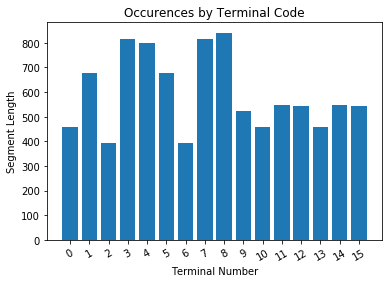

In [10]:
import matplotlib.pyplot as plt
import numpy as np

test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

label = []
length = []
for x in test_rows:
    label.append(x[0])
    length.append(x[1])
print(label)
print(length)

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, length)
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Occurences by Terminal Code')
    plt.show()
plot_bar_x()

# Number of Connections by Terminal

-1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[-1, 4, 0, 2, 0, 4, 0, 2, -1, 12, 9, 8, 8, 14, 10, 14]
[3, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 1, 0, 2, 0]


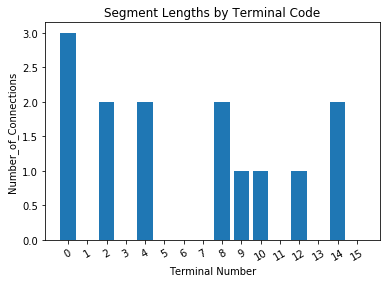

In [11]:
import matplotlib.pyplot as plt
import numpy as np


test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

for x in test_rows:
    if x[2] == None:
        x[2] = -1
print(test_rows[0][2])



occ_count = []
label = []
length = []
for x in test_rows:
    label.append(x[0])
    length.append(x[2])

occ_count = []

for x in label:
    occ_count.append(length.count(x))

   
print(label)
print(length)
print(occ_count)
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, occ_count)
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Number_of_Connections', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

### Segment Lengths by Terminal Code by Increasing Magnitude

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[456, 678, 394, 815, 798, 679, 394, 815, 841, 524, 458, 548, 543, 458, 548, 543]


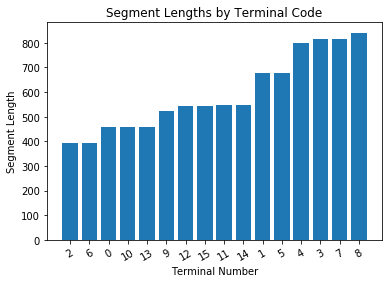

(2, 6, 0, 10, 13, 9, 12, 15, 11, 14, 1, 5, 4, 3, 7, 8)
(394, 394, 456, 458, 458, 524, 543, 543, 548, 548, 678, 679, 798, 815, 815, 841)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

label = []
length = []
for x in test_rows:
    label.append(x[0])
    length.append(x[1])
print(label)
print(length)


length, label = zip(*sorted(zip(length, label)))


def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, length)
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

print(label)
print(length)

# Average Lengths by Bin

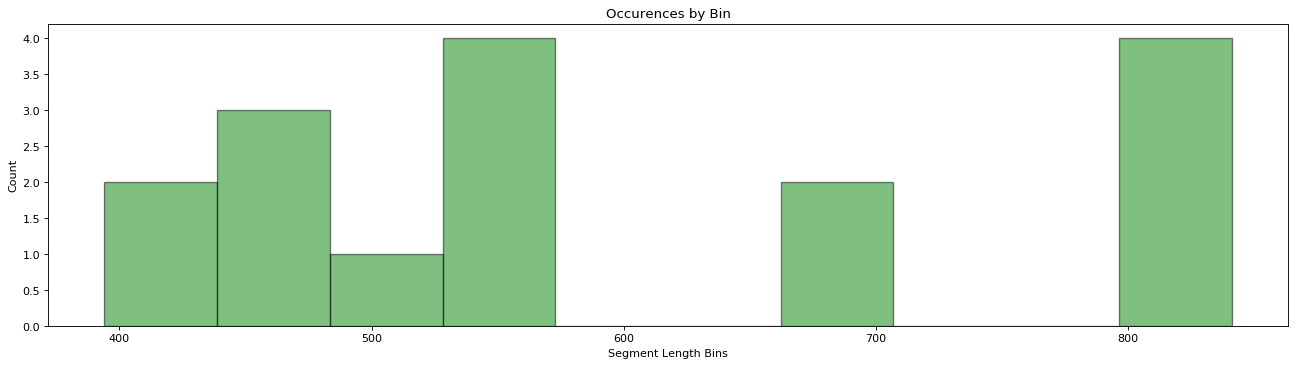

In [45]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
x = length
num_bins = 10
n, bins, patches = plt.hist(x, num_bins, facecolor='green', alpha=0.5,edgecolor='black', linewidth=1.2)
plt.xlabel('Segment Length Bins', fontsize=10)
plt.ylabel('Count', fontsize=10)

plt.title('Occurences by Bin')
plt.show()

# Full visualization of Brazos Network Followed by Largest 20

In [19]:
terminal_keys = Brazos_LowerColorado_ge5_values[4] 
circular_keys = Brazos_LowerColorado_ge5_values[6]
terminal_keys_super = terminal_keys - circular_keys
con = Brazos_LowerColorado_ge5_values[0]
terminal_code = terminal_code_NHD

B_labels = []
B_lengths = []
dict1 = []
new_coor = []
for x in con.keys():
    B_labels.append(x)
    
B_lengths = list(con.values())

for x in range(0,len(B_lengths)):
    fx = ((B_lengths[x]))
    new_coor.append(int(fx['length']))



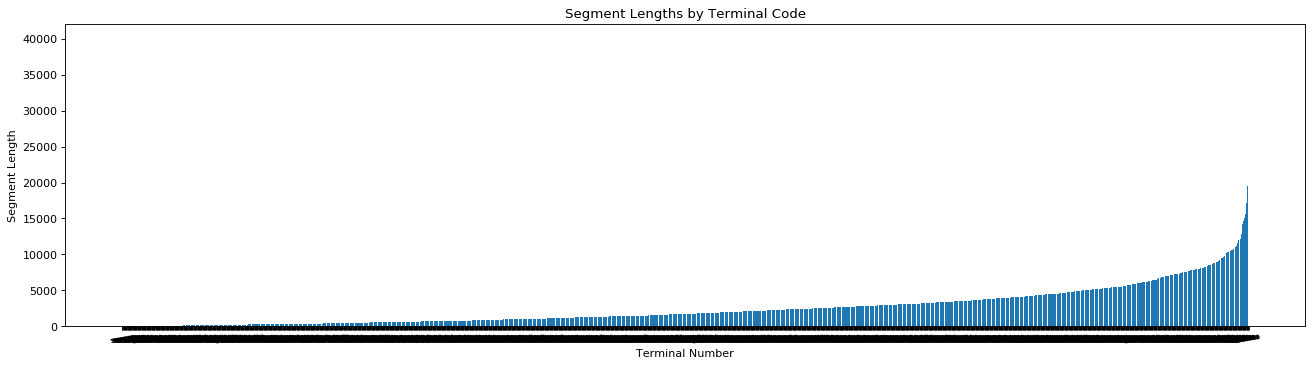

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')

new_coor, B_labels = zip(*sorted(zip(new_coor, B_labels)))

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(B_labels))
    plt.bar(index, new_coor)
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, B_labels, fontsize=5, rotation=10)
    plt.title('Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

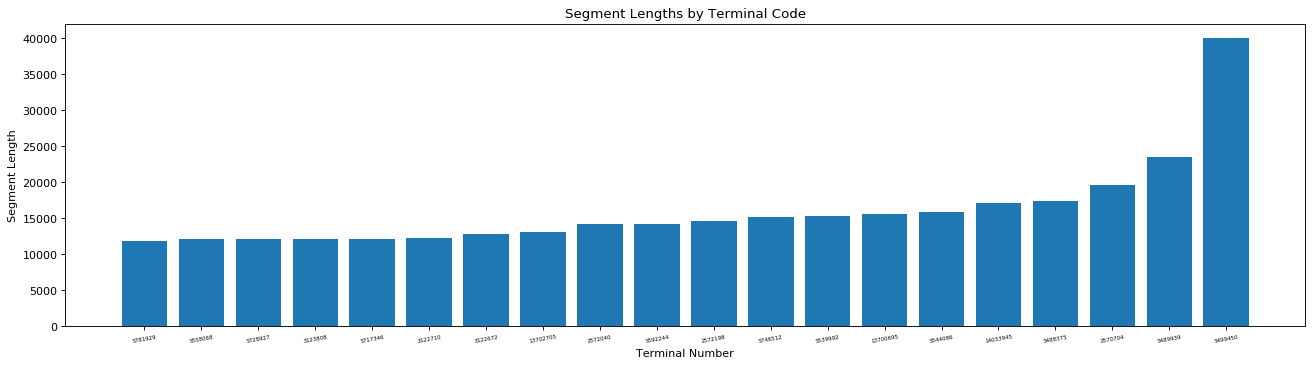

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')

new_coor, B_labels = zip(*sorted(zip(new_coor, B_labels)))


def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(B_labels[-20:]))
    plt.bar(index, new_coor[-20:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, B_labels[-20:], fontsize=5, rotation=10)
    plt.title('Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()



### Averages by Terminal Code - min,max,std,var,lengths - Requires Node_Order

In [30]:
#original 
import time

#list of the different key sets
#
# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
# terminal_code = terminal_code_NHD
# #
# terminal_keys = CONUS_ge5_values[4] 
# circular_keys = CONUS_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_ge5_values[0]
# #
# terminal_keys_super = test_terminal_keys - test_circular_keys
# # con = test_connections
# terminal_code = test_terminal_code

# terminal_keys = CONUS_FULL_RES_values[4] 
# circular_keys = CONUS_FULL_RES_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_FULL_RES_values[0]
# terminal_code = terminal_code_NHD
#orders of everything for computation in dictionary format
order_dict={}
junc_dict={}
head_dict={}
terminal_avg = {}

def recursive_junction_read (keys, iterator, con, network, terminal_code, verbose = False, debuglevel = 0):
    # print(keys)
    for key in keys:        
        result = 'node' + str(key) 
        order_dict[result] = iterator, nid
        ckey = key
        ukeys = con[key]['upstreams']
        # terminal key and node_order assignment 
        con[key].update({'nid': nid})
        con[key].update({'node_order' : iterator})
        n = []
        while not len(ukeys) >= 2 and not (ukeys == {terminal_code}):
            # the terminal code will indicate a headwater
            if debuglevel <= -2: print(ukeys)
            (ckey,) = ukeys
            ukeys = con[ckey]['upstreams']
            network['segment_count'] += 1
            #adds ordering for all nodes
            result = 'node' + str(ckey)
            order_dict[result] = iterator, nid
            #assignment of terminal key and node order adjustment for continuous serial orders without junctions
            con[ckey].update({'nid': nid})
            con[ckey].update({'node_order' : iterator+1+sum(n)})
            n.append(1)
            
        if len(ukeys) >= 2:
            if debuglevel <= -1: print(f"junction found at {ckey} with upstreams {ukeys}")
            network['segment_count'] += 1

            network['junction_count'] += 1 #the Terminal Segment
            #iterator adds 1 each iteration to provide a new order of computation for each junction section not each node or group of segments
            result_junc = 'junc' + str(key)
            junc_dict[result_junc] = iterator
            con[ckey].update({'nid': nid})
            
            recursive_junction_read (ukeys, iterator+1+sum(n), con, network, terminal_code, verbose, debuglevel)
            n.clear()
        elif ukeys == {terminal_code}:
            # print(f"headwater found at {ckey}")
            network['segment_count'] += 1
            #below adds headwaters to the headwater list
            result_head = 'head' + str(key)
            head_dict[result_head] = iterator
            con[ckey].update({'nid': nid})
            
      
def super_network_trace(nid, iterator, con, network, terminal_code, debuglevel = 0):
    # print(f'\ntraversing upstream on network {nid}:')
    try:
        network.update({'junction_count': 0})
        network.update({'segment_count': 0}) #the Terminal Segment
        
        recursive_junction_read([nid], iterator , con, network, terminal_code, debuglevel = debuglevel)
        
    except Exception as exc:
        print(exc)

super_networks = {terminal_key:{}
                        for terminal_key in terminal_keys_super}
debuglevel = 0

start_time = time.time()
for nid, network in super_networks.items():
    super_network_trace(nid, 0, con, network, terminal_code, debuglevel = debuglevel)
    

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.003437042236328125 seconds ---


In [36]:
import numpy as np

# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
# terminal_code = terminal_code_NHD
# terminal_keys = CONUS_ge5_values[4] 
# circular_keys = CONUS_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = CONUS_ge5_values[0]

# terminal_keys_super = test_terminal_keys - test_circular_keys
# con = test_connections
# terminal_code = test_terminal_code
# terminal_keys = test_terminal_keys
g2l = []



for x in new_order:
    for y, z in con.items():
        if x == z['node_order']:
          g2l.append(y)

count = []
count2 = []
totals_list = []
max_list = []
min_list = []
std_dev = []
var = []


for x in list(terminal_keys):
    for f, g in con.items():
        if g['nid'] == x:
            count.append(g['length'])
            count2.append(1)
            
    totals_list.append(int(sum(count)/sum(count2)))
    max_list.append(int(max(count)))  
    min_list.append(int(min(count)))
    std_dev.append(int(np.std(count)))
    var.append(int(np.var(count)))

print(totals_list, "Averages for each river system")
print(terminal_keys, 'Terminal Keys')
print(max_list, 'Maxs for each river system')
print(min_list, 'Minimums for each river system')
print(std_dev, 'Standard Deviation for each river system')
print(var, "Variance for each river system")

[3080, 2561] Averages for each river system
{3125212, 3766342} Terminal Keys
[39982, 39982] Maxs for each river system
[6, 1] Minimums for each river system
[3165, 2739] Standard Deviation for each river system
[10021714, 7505929] Variance for each river system


# Plotting of Previous Outputs

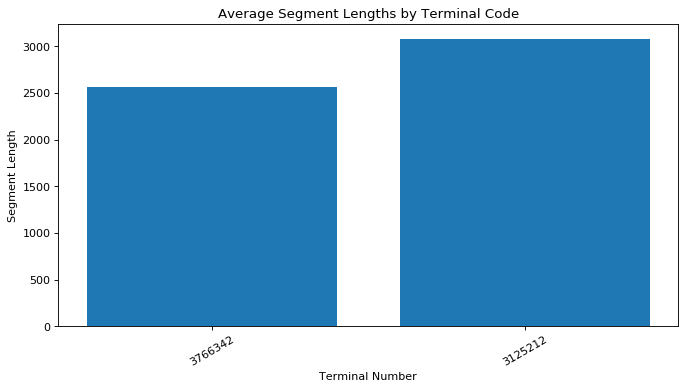

(3766342, 3125212)


In [37]:
import matplotlib.pyplot as plt
import numpy as np


totals_list, terminal_keys = zip(*sorted(zip(totals_list, terminal_keys)))

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len((terminal_keys)[-20:]))
    plt.bar(index, totals_list[-20:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, (terminal_keys)[-20:], fontsize=10, rotation=30)
    plt.title('Average Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

print(terminal_keys)

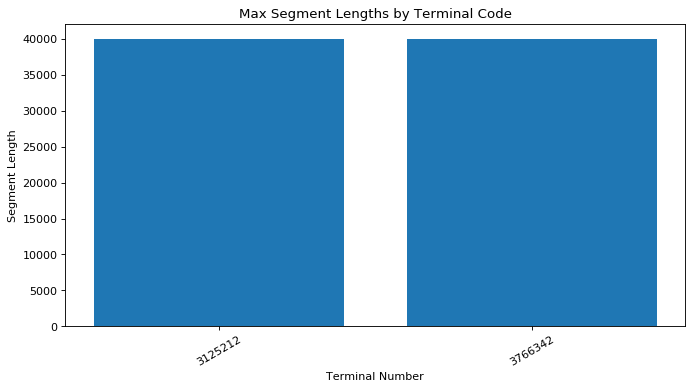

(3125212, 3766342)


In [39]:
import matplotlib.pyplot as plt
import numpy as np


max_list, terminal_keys = zip(*sorted(zip(max_list, terminal_keys)))

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len((terminal_keys)[:]))
    plt.bar(index, max_list[:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, (terminal_keys)[:], fontsize=10, rotation=30)
    plt.title('Max Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

print(terminal_keys)

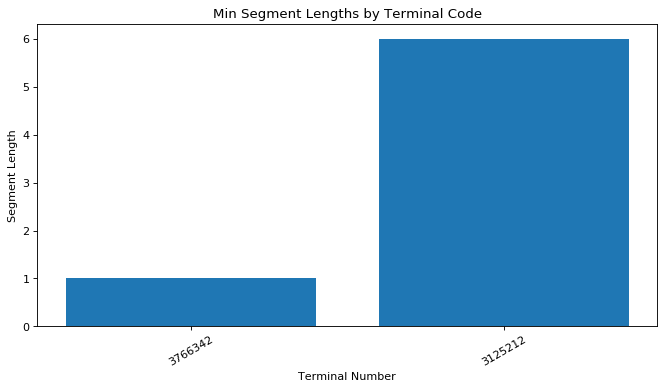

(3766342, 3125212)


In [41]:
import matplotlib.pyplot as plt
import numpy as np


min_list, terminal_keys = zip(*sorted(zip(min_list, terminal_keys)))

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len((terminal_keys)[:]))
    plt.bar(index, min_list[:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, (terminal_keys)[:], fontsize=10, rotation=30)
    plt.title('Min Segment Lengths by Terminal Code')
    plt.show()
plot_bar_x()

print(terminal_keys)

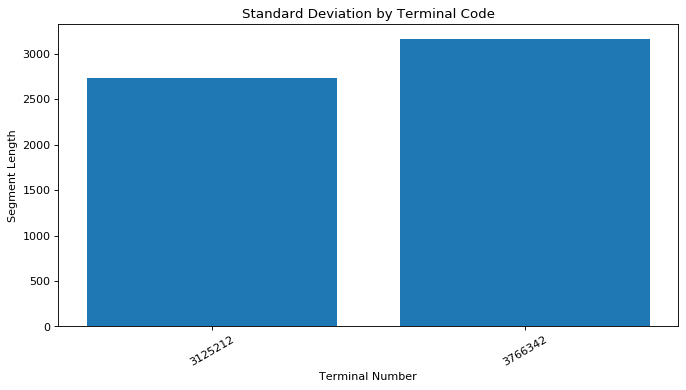

(3125212, 3766342)


In [42]:
import matplotlib.pyplot as plt
import numpy as np


std_dev, terminal_keys = zip(*sorted(zip(std_dev, terminal_keys)))

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len((terminal_keys)[:]))
    plt.bar(index, std_dev[:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Segment Length', fontsize=10)
    plt.xticks(index, (terminal_keys)[:], fontsize=10, rotation=30)
    plt.title('Standard Deviation by Terminal Code')
    plt.show()
plot_bar_x()

print(terminal_keys)

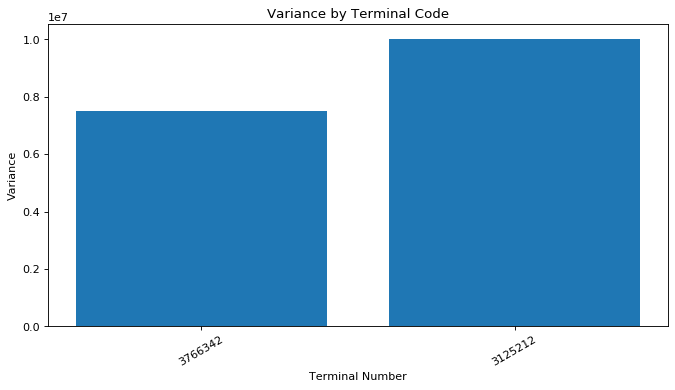

(3766342, 3125212)


In [43]:
import matplotlib.pyplot as plt
import numpy as np


var, terminal_keys = zip(*sorted(zip(var, terminal_keys)))

figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len((terminal_keys)[:]))
    plt.bar(index, var[:])
    plt.xlabel('Terminal Number', fontsize=10)
    plt.ylabel('Variance', fontsize=10)
    plt.xticks(index, (terminal_keys)[:], fontsize=10, rotation=30)
    plt.title('Variance by Terminal Code')
    plt.show()
plot_bar_x()

print(terminal_keys)